In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, GridSearchCV, RandomizedSearchCV

In [2]:
# importing dataset
from google.colab import files
uploaded = files.upload()

Saving ML-CUP23-TR.csv to ML-CUP23-TR.csv


In [3]:
# importing dataset
from google.colab import files
uploaded1 = files.upload()

Saving ML-CUP23-TS.csv to ML-CUP23-TS.csv


In [4]:
import io
df_traincup = pd.read_csv(io.BytesIO(uploaded['ML-CUP23-TR.csv']), names=['id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'target_x', 'target_y', 'target_z'], delimiter=',')

In [5]:
import io
df_testcup = pd.read_csv(io.BytesIO(uploaded1['ML-CUP23-TS.csv']), names=['id', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7', 'col8', 'col9', 'col10', 'target_x', 'target_y', 'target_z'], delimiter=',')

In [6]:
def split_data(data: pd.DataFrame, cols_name_split: list, rows_split_perc=1):
  '''
      It makes the split of the columns passed in \"cols_name_split\" and the split of the rows based on the \
      percentage \"rows_split_perc\".\n
      If \"cols_name_split\" = [] -> the method returns: (data, None).\n
      else -> (data_splitted_x, data_splitted_y) with rows_split_perc=1 \
          or (data_splitted_x_train, data_splitted_y_train, data_splitted_x_val, data_splitted_y_val) with rows_split_perc!=1.\n
      So this method makes split on columns or on rows (or both).\n\n
      Returns a tuple of two new DataFrames: (x,y).\n
      - x: is like \"df\" without the columns specified in the list \"cols_name_split\".\n
      - y: are the columns indentified by the list \"cols_name_split\".\n
      or a tuple of this format (x_train, y_train, x_val, y_val) with:
      - x_train: is like \"df\" without the columns specified in the list \"cols_name_split\".\n
      - y_train: are the columns indentified by the list \"cols_name_split\" used for Training.\n
      - x_val: is like \"df\" without the columns specified in the list \"cols_name_split\".\n
      - y_val: are the columns indentified by the list \"cols_name_split\" used for Validation.\n\n
      The parameters are:\n
      - df: the input DataFrame.\n
      - cols_name_split: list of names of target columns.\n
      - rows_split_perc: percentage of the data to split for Training, and so the 1-rows_split_perc percentage for Validation.
  '''
  # Case of no columns split
  if cols_name_split == []:
      # Case of rows split
      if rows_split_perc != 1:
          return np.split(data, [int(data.shape[0] * rows_split_perc)], axis=0)
      # Case of no rows and no columns split
      else:
          raise ValueError

  # Columns split
  y = data[cols_name_split].copy(deep=True)
  x = data.drop(columns=cols_name_split,axis=1).copy(deep=True)

  # Case of only columns split
  if rows_split_perc == 1:
      return x, y

  # Case of both splits (rows split and columns split)
  else:
      #x_train = x[:int(x.shape[0] * rows_split_perc), :]
      #x_val = x[int(x.shape[0] * rows_split_perc):, :]
      x_train, x_val = np.split(x, [int(x.shape[0] * rows_split_perc)], axis=0)
      #y_train = y[:int(x.shape[0] * rows_split_perc), :]
      #y_val = y[int(x.shape[0] * rows_split_perc):, :]
      y_train, y_val = np.split(y, [int(y.shape[0] * rows_split_perc)], axis=0)
      return x_train, y_train, x_val, y_val

In [7]:
# Saving the ID columns
df_id_train: pd.DataFrame = df_traincup['id']
df_id_test: pd.DataFrame = df_testcup['id']

# Drop the ID columns
df_train = df_traincup.drop(columns=['id'],axis=1).copy(deep=True)
df_test = df_testcup.drop(columns=['id'],axis=1).copy(deep=True)

# Split of columns and rows (0.8/0.2) into: TR set and Internal TS set
x_train, y_train, x_internal_test, y_internal_test = split_data(
    data=df_train,
    cols_name_split=['target_x','target_y','target_z'],
    rows_split_perc=0.8
)

# Split on columns
x_test, y_test = split_data(data=df_test, cols_name_split=['target_x','target_y','target_z'])

# Print of the shapes
print(f"[IDs TR SET]: " + str(df_id_train.shape))
print(f"[IDs TS SET]: " + str(df_id_test.shape))
print(f"[TR SET - x]: " + str(x_train.shape))
print(f"[TR SET - y]: " + str(y_train.shape))
print(f"[Internal TS SET - x]: " + str(x_internal_test.shape))
print(f"[Internal TS SET - y]: " + str(y_internal_test.shape))
print(f"[TS SET - x]: " + str(x_test.shape))
print(f"[TS SET - y]: " + str(y_test.shape))

[IDs TR SET]: (1000,)
[IDs TS SET]: (900,)
[TR SET - x]: (800, 10)
[TR SET - y]: (800, 3)
[Internal TS SET - x]: (200, 10)
[Internal TS SET - y]: (200, 3)
[TS SET - x]: (900, 10)
[TS SET - y]: (900, 3)


In [8]:
# Define custom loss function
def euclidean_distance_loss(y_true, y_pred):
    return np.sqrt(np.sum(np.square(y_pred - y_true)))

# Define a custom scorer based on the custom loss function
def MEE(y_true, y_pred):
    return np.mean(euclidean_distance_loss(y_true, y_pred))

# Use make_scorer to create a scorer suitable for RandomizedSearchCV
scorer = make_scorer(MEE, greater_is_better=False)

### STANDARDIZATION

In [9]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_train=pd.DataFrame(x_train_std)

In [10]:
scaler.fit(x_internal_test)
x_internal_test_std = scaler.transform(x_internal_test)
x_internal_test = pd.DataFrame(x_internal_test_std)

In [11]:
scaler.fit(y_train)
y_train_std = scaler.transform(y_train)
y_train = pd.DataFrame(y_train_std)

In [12]:
scaler.fit(y_internal_test)
y_internal_test_std = scaler.transform(y_internal_test)
y_internal_test = pd.DataFrame(y_internal_test_std)

### TRAINING

Text(0, 0.5, 'MEE score')

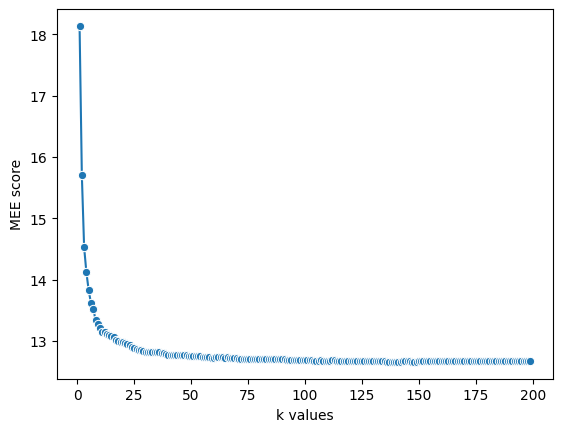

In [16]:
k_values = [i for i in range (1,200)]
scores = []
X_train, y_train = shuffle(x_train, y_train, random_state=37)

for k in k_values:
  knn = KNeighborsRegressor(n_neighbors=k)
  score = cross_val_score(knn, x_train, y_train, cv=5, scoring=make_scorer(MEE, greater_is_better=False))
  scores.append(-np.mean(score))

sns.lineplot (x= k_values, y= scores, marker= "o")
plt.xlabel("k values")
plt.ylabel("MEE score")

"greater is better= False", in scoring, suggeriche al cross_val_score che l'obbiettivo è minimizzare lo score dato da MEE


In [59]:
params = {
    'n_neighbors': np.arange(1,110),
    'algorithm': ['auto']
}

In [ ]:
#hyperparameter tuning with GridSearchCV

knn_search = KNeighborsRegressor()
knr_cv = GridSearchCV(estimator=knn_search, param_grid=params, scoring=make_scorer(mean_squared_error, greater_is_better=False), cv=5, verbose=4)
knr_cv.fit(x_train, y_train)


In [ ]:
knr_cv.best_params_

In [ ]:
#validation
knr_cv.best_score_

In [ ]:
knr = knr_cv.best_estimator_
train_pred_knr = knr.predict(x_train)
print('MEE train set: ', MEE(y_train, train_pred_knr))

In [ ]:
int_test_pred_knr = knr.predict(x_internal_test)
print ('MEE internal test set: ', MEE(y_internal_test, int_test_pred_knr))